In [13]:
!unzip /Faces.zip

unzip:  cannot find or open /Faces.zip, /Faces.zip.zip or /Faces.zip.ZIP.


In [2]:
import os
from tqdm import tqdm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.decomposition import PCA

In [3]:
from utils import create_images_list

# Preparación de los datos

In [1]:
import importlib
import constants
importlib.reload(constants)
from constants import (BACKGROUND_PATH)

In [16]:
facesPath = 'Faces' # use '/content/Faces' on colab
faces = create_images_list([facesPath])
faces.shape


100%|██████████| 12833/12833 [00:02<00:00, 5215.75it/s]


(12833, 64, 64)

In [17]:
fondos = create_images_list([ BACKGROUND_PATH])
fondos.shape

100%|██████████| 12800/12800 [00:03<00:00, 3969.06it/s]


(12800, 64, 64)

In [30]:
# Flatten
rostros_flat = faces.reshape(faces.shape[0], -1)
fondos_flat = fondos.reshape(fondos.shape[0], -1)

# Combinar
X = np.array([im.flatten() for im in tqdm(faces, desc='Construyendo X')])
X = np.vstack((rostros_flat, fondos_flat))  # forma (N_total, 4096)
y = np.array([1]*faces.shape[0] + [0]*fondos.shape[0])  # 1=rostro, 0=fondo

images = list(faces) + list(fondos)

Construyendo X: 100%|██████████| 12833/12833 [00:00<00:00, 579391.85it/s]


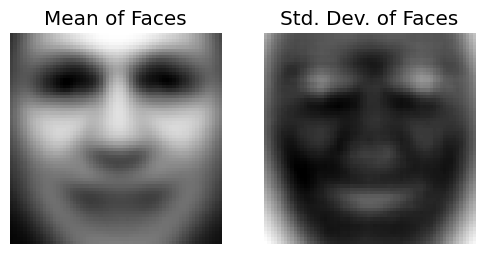

In [31]:
# Calculamos la imagen promedio y la desviación estándar para cada dígito
mean_images = np.mean(images, axis=0)
std_images = np.std(images, axis=0)

# Visualizamos las imágenes promedio y las desviaciones estándar
fig, axs = plt.subplots(1, 2, figsize=(6, 6))

axs[0].imshow(mean_images, cmap='gray')
axs[0].set_title(f"Mean of Faces")
axs[0].axis('off')

axs[1].imshow(std_images, cmap='gray')
axs[1].set_title(f"Std. Dev. of Faces")
axs[1].axis('off')

plt.show()

# PCA

In [32]:
X = np.array([im.flatten() for im in tqdm(images, desc='Construyendo X')])

Construyendo X: 100%|██████████| 25633/25633 [00:00<00:00, 490047.93it/s]


In [33]:
X.shape

(25633, 4096)

In [34]:
# PCA
pca = PCA(n_components=200, whiten=False).fit(X)

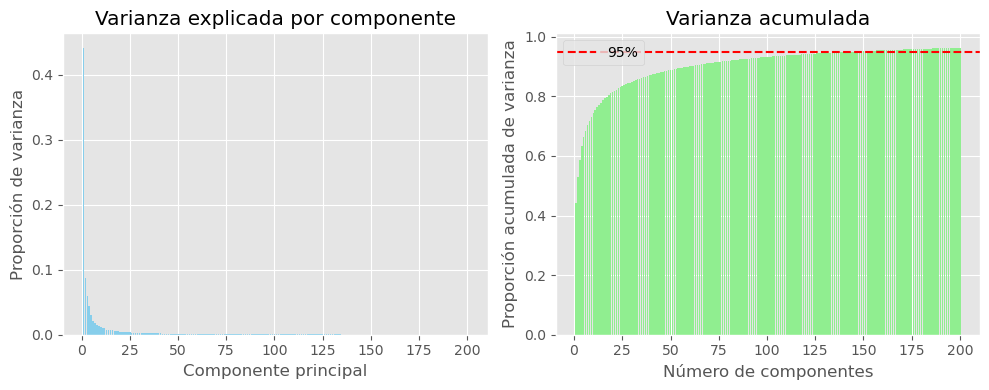

In [25]:
# Obtener varianzas
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Varianza explicada
ax1.bar(range(1, len(var_explicada)+1), var_explicada, color='skyblue')
ax1.set_title('Varianza explicada por componente')
ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Proporción de varianza')
ax1.grid(True)

# Varianza acumulada
ax2.bar(range(1, len(var_acumulada)+1), var_acumulada, color='lightgreen')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax2.set_title('Varianza acumulada')
ax2.set_xlabel('Número de componentes')
ax2.set_ylabel('Proporción acumulada de varianza')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Visualización

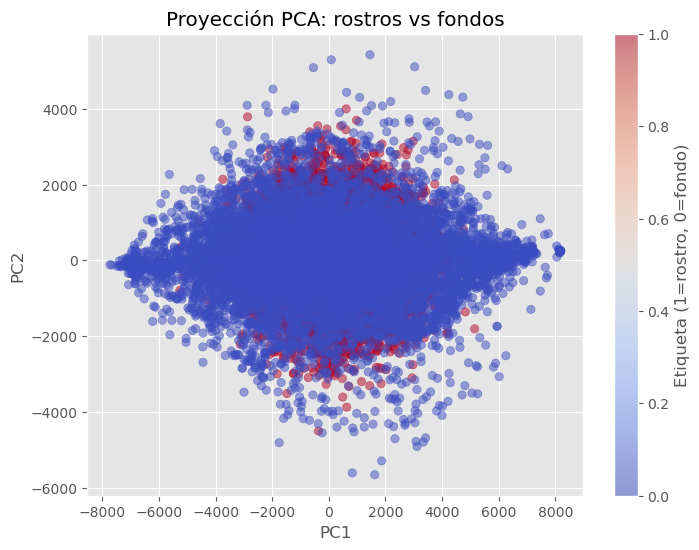

In [28]:
X_pca = pca.transform(X)
y = np.array([1]*len(faces) + [0]*len(fondos))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección PCA: rostros vs fondos')
plt.colorbar(label='Etiqueta (1=rostro, 0=fondo)')
plt.grid(True)
plt.show()

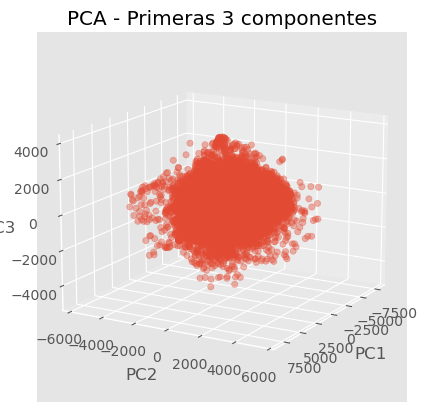

In [35]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], alpha=0.4)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

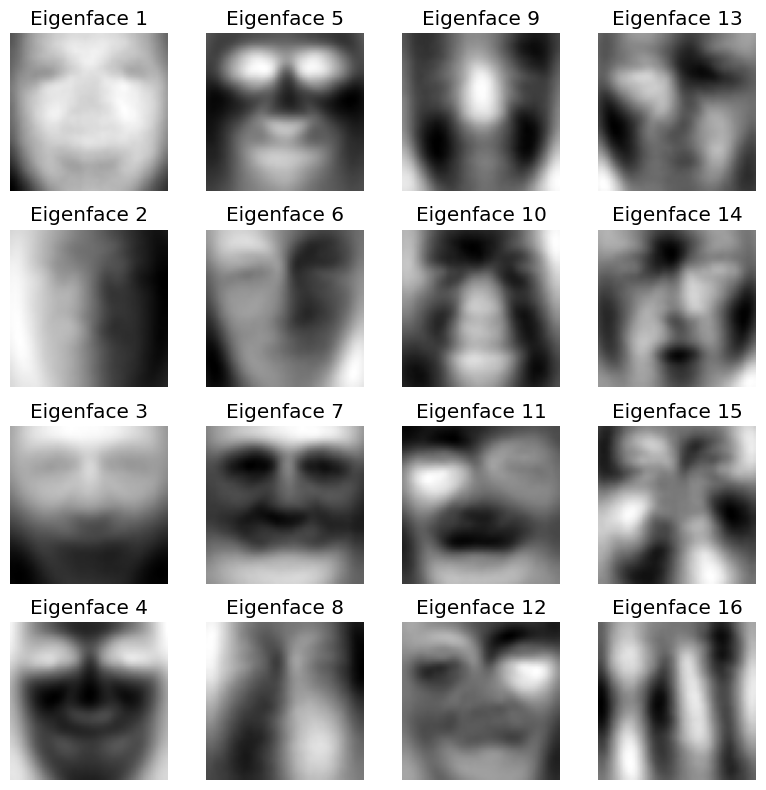

In [36]:
# Primeras K eigenfaces
K = 16
eigenfaces = pca.components_[:K]
faceshape = faces[0].shape
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
for i in range(K):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
    axes[i%4][i//4].set_title(f"Eigenface {i+1}")
    axes[i%4][i//4].axis('off')

plt.tight_layout()
plt.show()

In [37]:
df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200
0,2069.219405,-345.603339,-174.665545,-591.099048,80.627501,354.949915,58.379175,-108.002242,-155.174726,-380.083614,...,20.679586,30.701013,-9.902518,8.199260,-16.669376,23.296184,85.588788,50.911305,-14.318216,46.522160
1,-617.076809,-480.657901,227.823537,-270.375045,303.954876,-155.364869,-353.420378,112.258791,-185.051209,-393.988814,...,-16.467798,16.732879,38.119967,-15.998382,17.274244,59.162716,66.194666,-85.162250,23.900655,15.518998
2,577.758543,-849.045268,379.301858,-317.921864,-789.328981,-2.119264,626.940770,-25.382721,-20.336789,55.672223,...,17.205892,24.993104,37.779948,20.850595,147.118970,-32.962291,31.092681,18.879665,66.059323,0.783592
3,718.829304,-1867.302483,-344.045718,-996.277947,302.791091,-298.131764,240.660254,-458.117567,89.540559,506.496145,...,93.803891,-31.105159,-32.528506,26.262014,90.473800,2.563525,-0.074596,114.982973,8.143688,2.026850
4,-1625.467627,-214.157943,22.851362,-783.807787,248.070252,177.610384,564.295101,280.479901,154.776774,66.620235,...,12.380354,5.541222,-45.838289,-17.086041,43.059284,-13.378956,60.808290,10.982120,57.087563,-13.033683


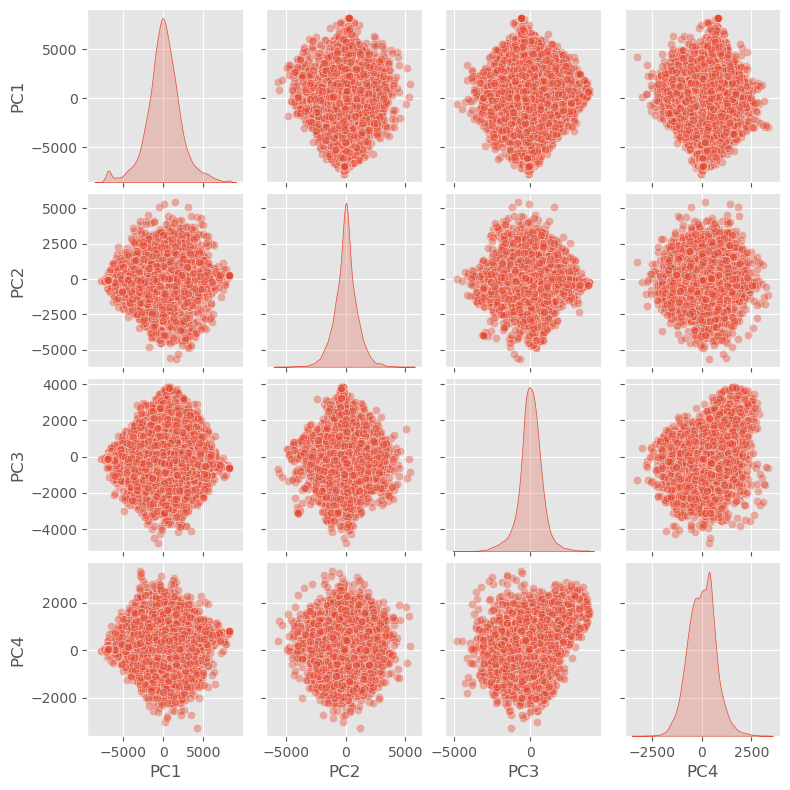

In [38]:
sns.pairplot(df[['PC1','PC2','PC3','PC4']], diag_kind='kde',height=2,plot_kws={'alpha':0.4})
plt.show()

# Reconstrucción

In [39]:
idx = 2050  # Índice de la imagen a reconstruir
original = X[idx]
pc_scores = X_pca[idx]

In [40]:
reconstructed_images = []
components_used = [10, 50, 100, 200]

for k in components_used:
    reconstruction = np.dot(pc_scores[:k], pca.components_[:k]) + pca.mean_
    reconstructed_images.append(reconstruction.reshape(faceshape))

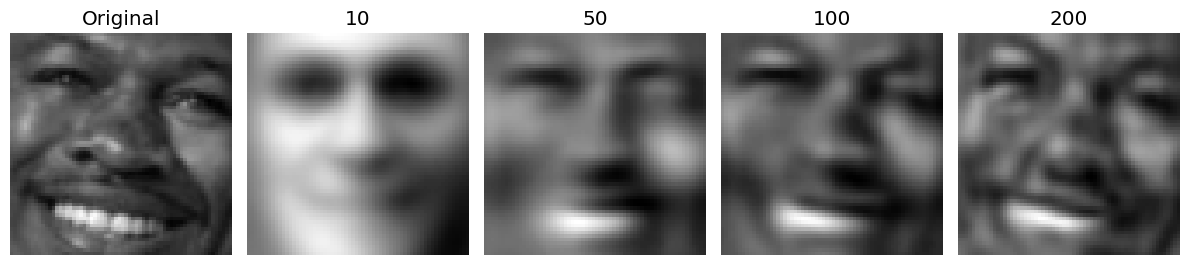

In [41]:
# Visualización
fig, axes = plt.subplots(1, len(components_used) + 1, figsize=(12, 4))

# Imagen original
axes[0].imshow(original.reshape(faceshape), cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

# Reconstrucciones
for i, img in enumerate(reconstructed_images):
    axes[i+1].imshow(img, cmap='gray')
    axes[i+1].set_title(f"{components_used[i]}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()